## How do choices in our neural network affect the performance of the model?

Previsously, we looked at how a neural (NN) and non-neural (non-NN) network can be utilised to classify data within a dataset - specifically the classes of objects within the SDSS DR18 dataset. In our notebooks we compared each approach to each other and worked on optimisation of our networks. This notebook aims to look further into that, specifically to answer the following questions: 

1) How does the amount of training data used affect the performance of the NN?
2) How does the balance of classes in a classification problem affect the performance of a neural network?

We aim to answer both these questions in this notebook - whilst assuming both prior notebooks have been read so the reader has a level of understanding as to how the NN and non-NN both operate. We will look to explore how changing the amount of training data can cause issues with the model - e.g. over and underfitting, and to explore the effects of imbalance of classes and how we can potentially resolve these issues within our modelling.

## Importing the libraries and reading the data ##

In [1]:
import kagglehub #used to get the data from kaggle.com
from kagglehub import KaggleDatasetAdapter #used to fetch the specific dataset from kaggle
import pandas as pd #used for viewing and manipulating the data
import matplotlib.pyplot as plt #used for data visulisation

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split as skl_tts
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report as skl_cr
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sys, os #imports sys and os, allows for modifying the path to get functions
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), ".."))) #changes the path to include the py folder and its contents (parent folder)

from functions import * #calls all functions from functions.py

In [2]:
import torch
import sklearn
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 2.9.0+cpu
Scikit-learn version: 1.7.2
Seaborn version: 0.13.2
Pandas version: 2.3.3
Matplotlib version: 3.10.7
NumPy version: 2.3.4


In [3]:
data = dataGrabber()

## Affects of changing the amounts of training data on the Neural Network ##

In [4]:
features = ['u', 'g', 'r', 'i', 'z']

x = data[features]
y = data['class']

labelEncoder = LabelEncoder()
yEncoded = labelEncoder.fit_transform(y)

scaler = StandardScaler()
xScaled = scaler.fit_transform(x)

test_size = 0.2
random_state = 12
xTrain, xTest, yTrain, yTest = dataSplitting(xScaled, yEncoded, test_size, random_state)

xTrainTensor = torch.tensor(xTrain, dtype = torch.float32) 
yTrainTensor = torch.tensor(yTrain, dtype = torch.long) 
xTestTensor = torch.tensor(xTest, dtype = torch.float32) 
yTestTensor = torch.tensor(yTest, dtype = torch.long)

trainData = TensorDataset(xTrainTensor, yTrainTensor)
testData = TensorDataset(xTestTensor, yTestTensor)
trainLoader = DataLoader(trainData, batch_size = 64, shuffle = True)
testLoader =  DataLoader(testData, batch_size = 64, shuffle = False)

model = NeuralNetworkClassifier()

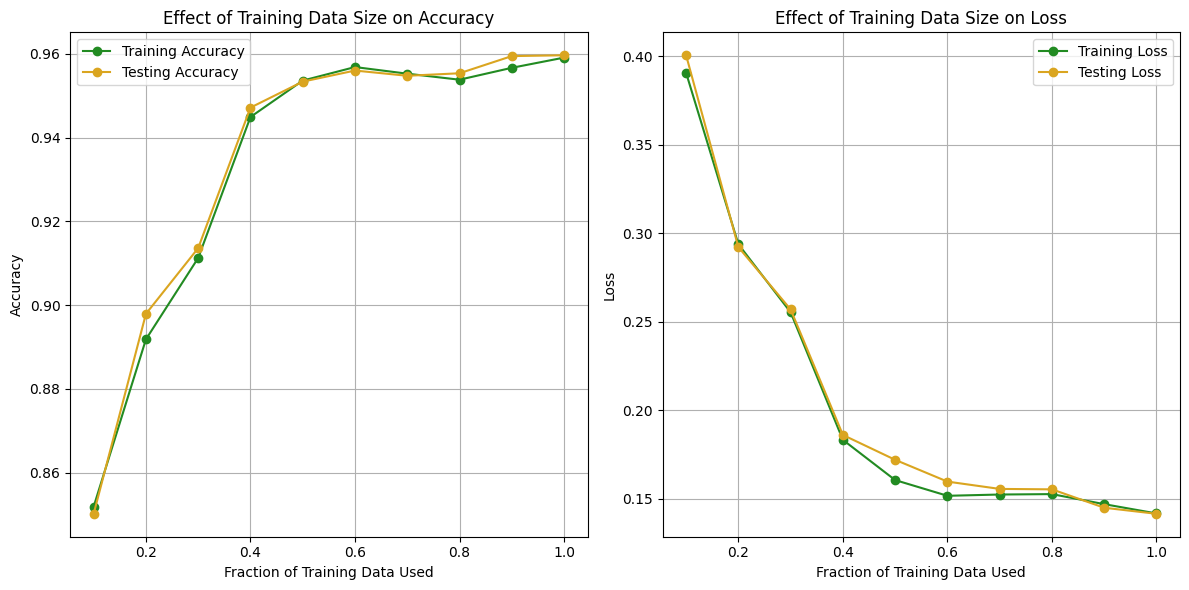

In [5]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
criteria = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = 0.001)
epochs = 25

def trainingDataSizeAffect(model, trainData, testLoader, fractions, criteria, optimiser, epochs):
    trainAccuracy = [] #stores accuracy of training
    testAccuracy = [] #stores accuracy of testing
    trainLoss = [] #stores loss of training
    testLoss = [] #stores loss of testing
    confMatrices = [] #stores confusion matrices
    
    for i in fractions:
        subsetSize = int(len(trainData) * i)
        subsetData, _ = torch.utils.data.random_split(trainData, [subsetSize, len(trainData) - subsetSize])
        subsetLoad = DataLoader(subsetData, batch_size = 64, shuffle = True)
    
        model.apply(lambda layer: layer.reset_parameters() if hasattr(layer, 'reset_parameters') else None)
        
        model.train()
        for j in range(epochs):
            for inputs, labels in subsetLoad:
                optimiser.zero_grad()
                outputs = model(inputs)
                loss = criteria(outputs, labels)
                loss.backward()
                optimiser.step()
                
        trainCorrect = 0
        trainTotal = 0
        runningTrainLoss = 0.0
        model.eval()
        
        with torch.no_grad():
            for inputs, labels in subsetLoad:
                outputs = model(inputs)
                loss = criteria(outputs, labels)
                runningTrainLoss += loss.item()
                _, predicted = torch.max(outputs, 1)
                trainCorrect += (predicted == labels).sum().item()
                trainTotal += labels.size(0)
        
        trainAccuracy.append(trainCorrect / trainTotal)
        trainLoss.append(runningTrainLoss / len(subsetLoad))
        
        testCorrect = 0
        testTotal = 0
        runningTestLoss = 0.0
        allLabels = []
        allPredictions = []
        
        with torch.no_grad():
            for inputs, labels in testLoader:
                outputs = model(inputs)
                loss = criteria(outputs, labels)
                runningTestLoss += loss.item()
                _, predicted = torch.max(outputs, 1)
                testCorrect += (predicted == labels).sum().item()
                testTotal += labels.size(0)
                allLabels.extend(labels.cpu().numpy())
                allPredictions.extend(predicted.cpu().numpy())
        
        testAccuracy.append(testCorrect / testTotal)
        testLoss.append(runningTestLoss / len(testLoader))
        
        confMatrix = confusion_matrix(allLabels, allPredictions)
        confMatrices.append((i, confMatrix))
    
    plt.figure(figsize = (12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fractions, trainAccuracy, marker = 'o', label = 'Training Accuracy', color = 'forestgreen')
    plt.plot(fractions, testAccuracy, marker ='o', label = 'Testing Accuracy', color = 'goldenrod')
    plt.title("Effect of Training Data Size on Accuracy")
    plt.xlabel("Fraction of Training Data Used")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(fractions, trainLoss, marker = 'o', label = 'Training Loss', color = 'forestgreen')
    plt.plot(fractions, testLoss, marker ='o', label = 'Testing Loss', color = 'goldenrod')
    plt.title("Effect of Training Data Size on Loss")
    plt.xlabel("Fraction of Training Data Used")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
    return confMatrices


confusionMatrices = trainingDataSizeAffect(model, trainData, testLoader, fractions, criteria, optimiser, epochs)

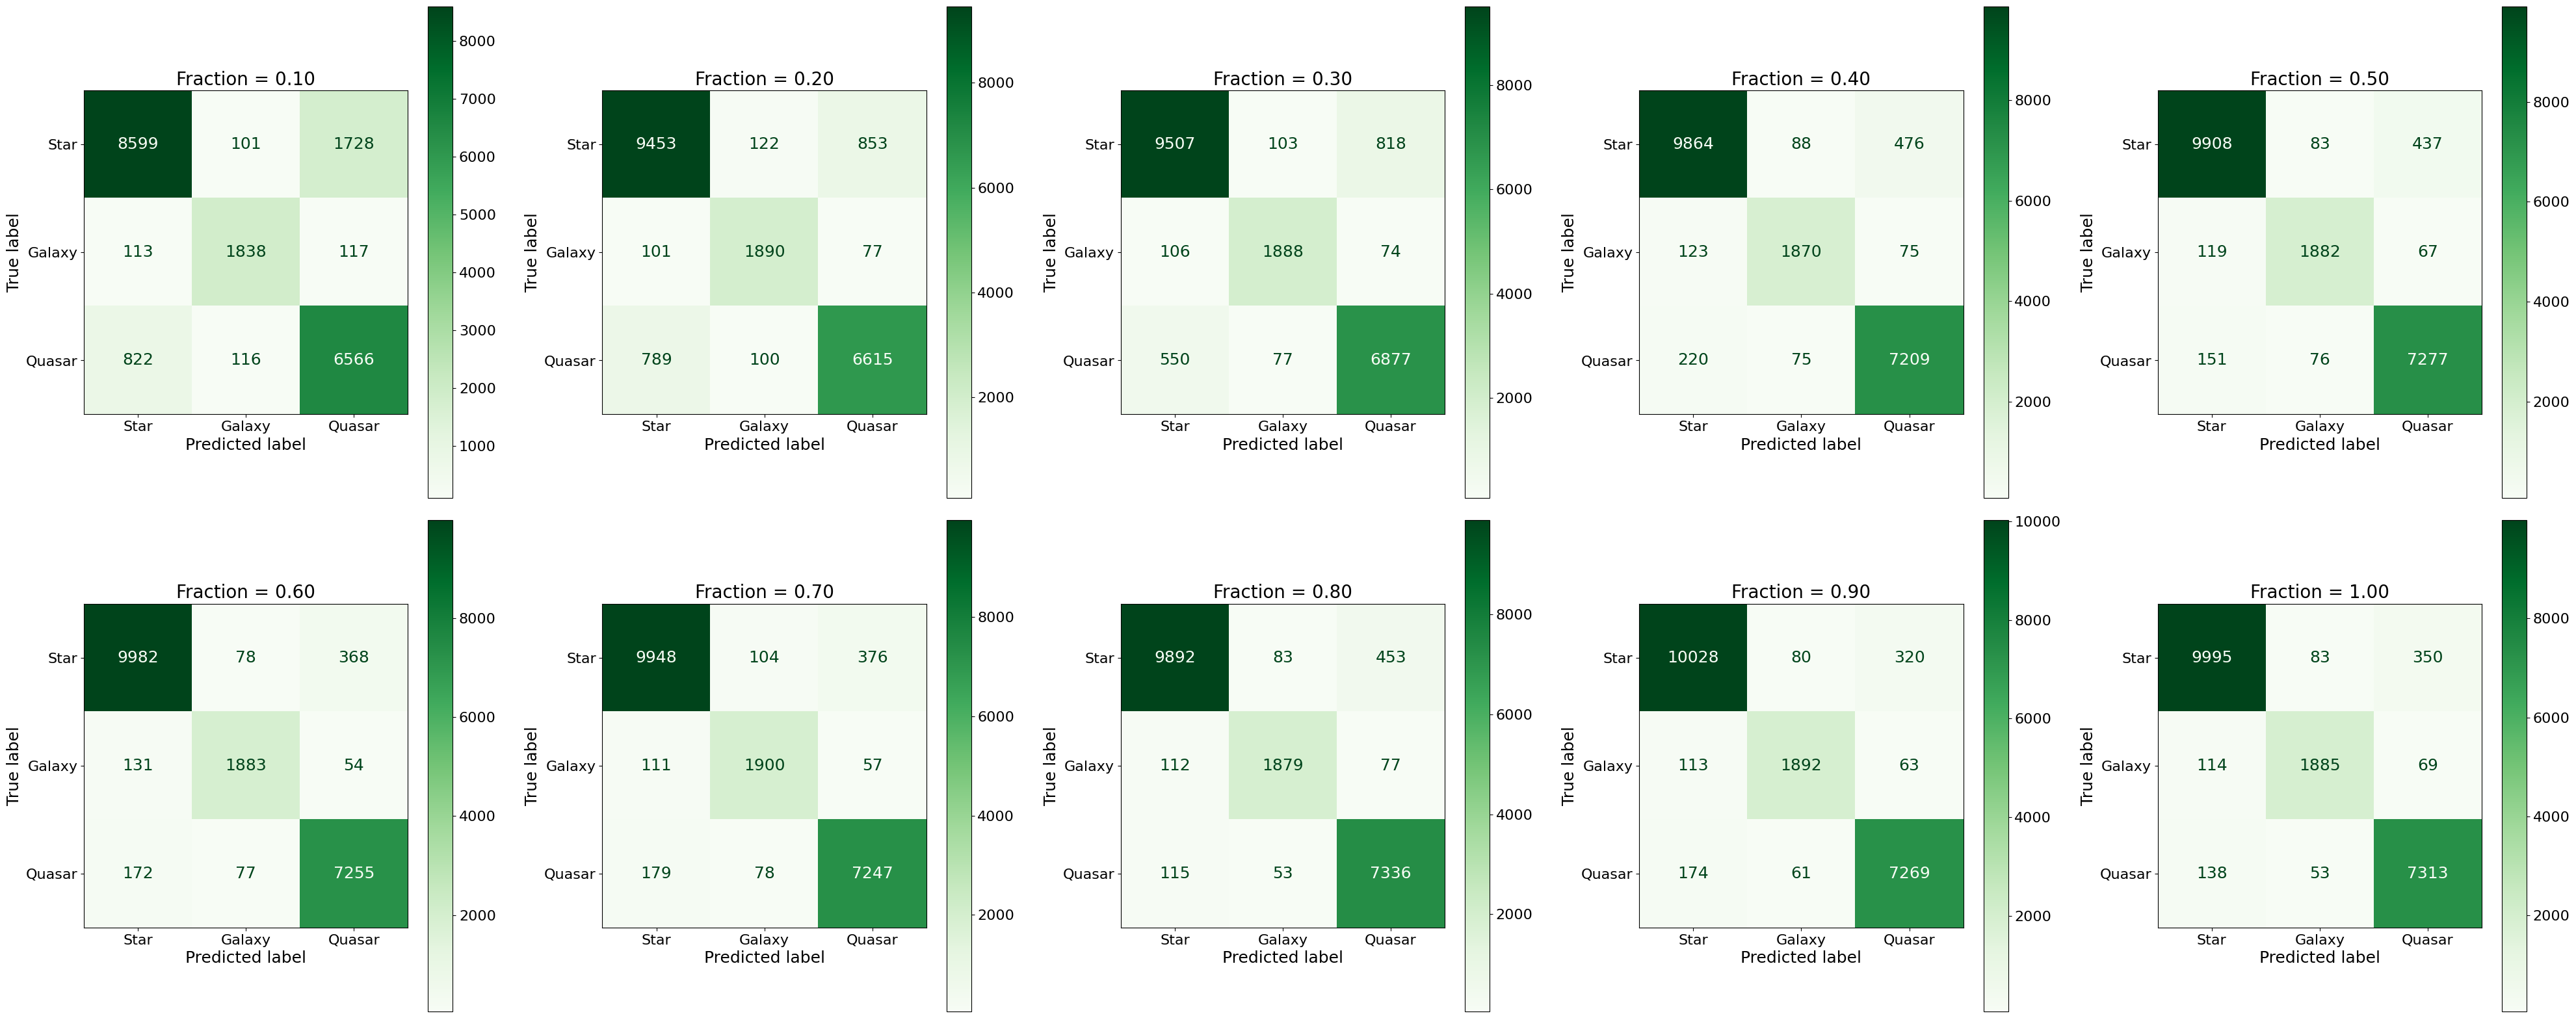

In [6]:
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

fig, axes = plt.subplots(2, 5, figsize=(40, 16))
axes = axes.flatten()

for ax, (i, confMatrix) in zip(axes, confusionMatrices):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confMatrix,
        display_labels=['Star', 'Galaxy', 'Quasar']
    )
    disp.plot(cmap="Greens", values_format="d", ax=ax, colorbar=True)
    ax.set_title(f"Fraction = {i:.2f}")

plt.tight_layout()
plt.show()